# HW 8: Bayesian Inference

### Due Tues April 19, 2022 @ 8pm

### Casey Lam, casey_lam@berkeley.edu

Inferring underlying properties of physical systems is a fairly ubiquitous requirement in data-driven fields. The following problem involves inferring the motion properties of two objects given (noisy, finite #) measurements over time.

Assume both objects move at a fixed speed/direction, and assume that there is a fixed measurement error (ie., the observed location in x,y is the true location plus some i.i.d. Gaussian random noise at time t).

Use PyMC and Bayesian inference to answer the following questions:

a) What is the posterior of the speed of each object?

In [1]:
import pandas as pd
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np 

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Load up data and take a look.

              t  red_pos_X  red_pos_Y  blue_pos_X  blue_pos_Y
0      1.718397   1.330174   0.993564    1.081700   -1.295918
1      2.998056   1.310404   1.012772    1.004997   -1.254394
2      6.015073   1.270312   1.028386    1.113696   -1.321257
3      8.267651   1.331131   0.948223    1.001845   -1.285209
4      9.279321   1.346159   0.963485    1.113008   -1.261147
..          ...        ...        ...         ...         ...
233  917.257513   1.508631  -1.102589    1.336283    0.731539
234  918.731229   1.527784  -1.089354    1.365426    0.704495
235  920.799970   1.548625  -1.114348    1.274398    0.851536
236  935.253542   1.546141  -1.122522    1.375008    0.789581
237  943.819854   1.519060  -1.131294    1.381119    0.873799

[238 rows x 5 columns]


Text(0, 0.5, 'Y pos')

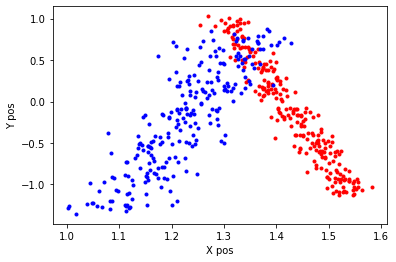

In [2]:
t = pd.read_csv('/home/jovyan/python-seminar/Homeworks/hw_8/location_data_hw8_2022.csv')
print(t)

plt.plot(t['red_pos_X'], t['red_pos_Y'], 'r.')
plt.plot(t['blue_pos_X'], t['blue_pos_Y'], 'b.')
plt.xlabel('X pos')
plt.ylabel('Y pos')

Make priors based on the data by fitting a straight line to position vs time.
(Yes I know you're not supposed to do this... but this seems more reasonable than guessing by eye.)

In [3]:
px_red = np.polyfit(t['t'], t['red_pos_X'], 1)
py_red = np.polyfit(t['t'], t['red_pos_Y'], 1)
px_blue = np.polyfit(t['t'], t['blue_pos_X'], 1)
py_blue = np.polyfit(t['t'], t['blue_pos_Y'], 1)

print(px_red)
print(py_red)
print(px_blue)
print(py_blue)

[2.58402337e-04 1.30230585e+00]
[-0.00226272  0.98191362]
[2.70710365e-04 1.09354086e+00]
[ 0.00226952 -1.30433238]


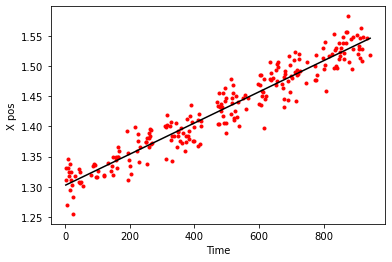

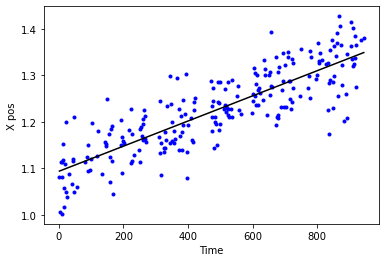

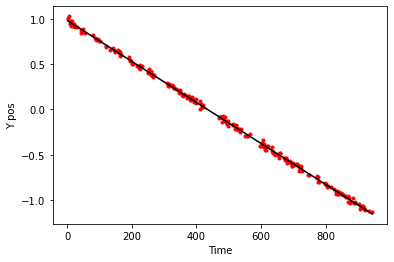

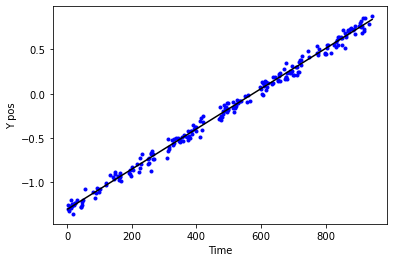

In [4]:
# Plot to check reasonable-ness of the fits.
times = np.linspace(t['t'].min(), t['t'].max(), 1000)
plt.plot(t['t'], t['red_pos_X'], 'r.')
plt.plot(times, px_red[0] * times + px_red[1], 'k')
plt.xlabel('Time')
plt.ylabel('X pos')
plt.show()

plt.plot(t['t'], t['blue_pos_X'], 'b.')
plt.plot(times, px_blue[0] * times + px_blue[1], 'k')
plt.xlabel('Time')
plt.ylabel('X pos')
plt.show()

plt.plot(t['t'], t['red_pos_Y'], 'r.')
plt.plot(times, py_red[0] * times + py_red[1], 'k')
plt.xlabel('Time')
plt.ylabel('Y pos')
plt.show()

plt.plot(t['t'], t['blue_pos_Y'], 'b.')
plt.plot(times, py_blue[0] * times + py_blue[1], 'k')
plt.xlabel('Time')
plt.ylabel('Y pos')
plt.show()

Define priors on m, b where position = m * time + b.
There is an m, b for each color (red, blue) and axis (x, y).
The priors are Gaussians centered on the best-fit straight line values calculated above, with a spread of 1.
Then for the likelihood, we multiply indiviual Gaussians likelihoods for the (x, y) positions of (red, blue).

In [5]:
with pm.Model() as model:
    sigma=1 # These points have no error-bars, so just give them all the same sigma.
    mx_red = pm.Normal("mx_red", mu=px_red[0], sigma=1)
    bx_red = pm.Normal("bx_red", mu=px_red[1], sigma=1)
    mx_blue = pm.Normal("mx_blue", mu=px_blue[0], sigma=1)
    bx_blue = pm.Normal("bx_blue", mu=px_blue[1], sigma=1)
    my_red = pm.Normal("my_red", mu=py_red[0], sigma=1)
    by_red = pm.Normal("by_red", mu=py_red[1], sigma=1)
    my_blue = pm.Normal("my_blue", mu=py_blue[0], sigma=1)
    by_blue = pm.Normal("by_blue", mu=py_blue[1], sigma=1)

    # Should this be multiplying or adding?? is the likelihood added or multiply?
    likelihood = pm.Normal("xred", mu=bx_red + mx_red*t['t'], sigma=sigma, observed=t['red_pos_X']) * \
                 pm.Normal("yred", mu=by_red + my_red*t['t'], sigma=sigma, observed=t['red_pos_Y']) * \
                 pm.Normal("xblue", mu=bx_blue + mx_blue*t['t'], sigma=sigma, observed=t['blue_pos_X']) * \
                 pm.Normal("yblue", mu=by_blue + my_blue*t['t'], sigma=sigma, observed=t['blue_pos_Y'])

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    step = pm.NUTS()
    trace = pm.sample(20000, step=[step], cores=2, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [by_blue, my_blue, by_red, my_red, bx_blue, mx_blue, bx_red, mx_red]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 52 seconds.


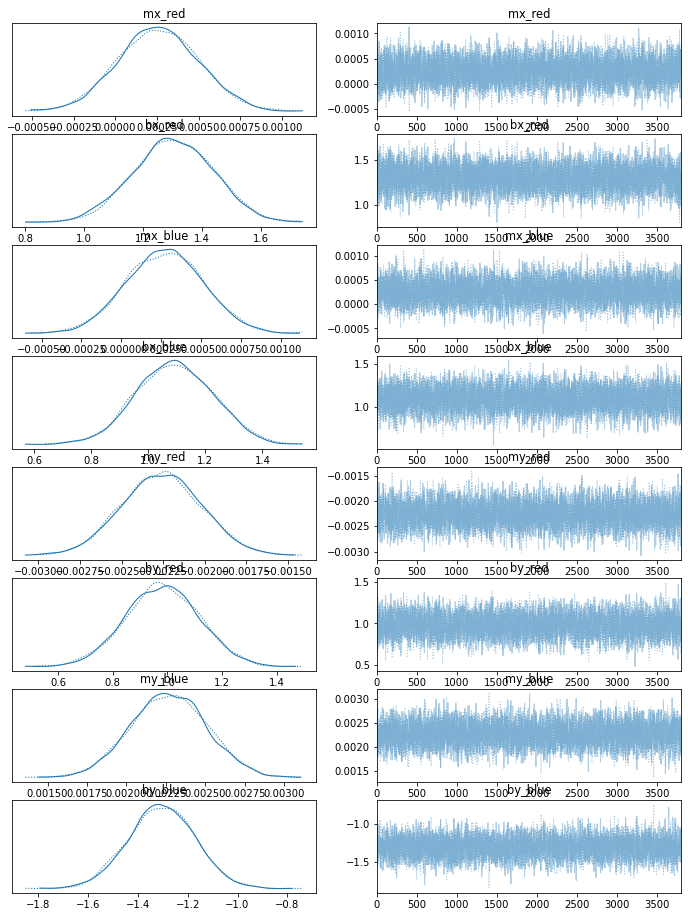

In [6]:
import arviz as az
with model:
    _ = az.plot_trace(trace[1000:][::5])

Calculate the median values (exclude the first 1000 samples for burn-in, only take every 5th sample for reducing correlation.)

In [7]:
mx_red_med = trace['mx_red'][1000:][::5].sum()/len(trace['mx_red'][1000:][::5])
bx_red_med = trace['bx_red'][1000:][::5].sum()/len(trace['bx_red'][1000:][::5])
my_red_med = trace['my_red'][1000:][::5].sum()/len(trace['my_red'][1000:][::5])
by_red_med = trace['by_red'][1000:][::5].sum()/len(trace['by_red'][1000:][::5])
mx_blue_med = trace['mx_blue'][1000:][::5].sum()/len(trace['mx_blue'][1000:][::5])
bx_blue_med = trace['bx_blue'][1000:][::5].sum()/len(trace['bx_blue'][1000:][::5])
my_blue_med = trace['my_blue'][1000:][::5].sum()/len(trace['my_blue'][1000:][::5])
by_blue_med = trace['by_blue'][1000:][::5].sum()/len(trace['by_blue'][1000:][::5])

(array([  1.,   1.,   2.,   1.,   2.,   7.,  10.,  11.,  19.,  36.,  33.,
         57.,  97., 114., 149., 182., 197., 278., 327., 312., 394., 474.,
        429., 437., 461., 456., 472., 446., 408., 373., 336., 257., 221.,
        210., 152., 122.,  91.,  79.,  62.,  27.,  16.,  14.,   7.,   5.,
          9.,   4.,   0.,   1.,   1.]),
 array([0.0013896 , 0.0014264 , 0.0014632 , 0.0015    , 0.0015368 ,
        0.00157359, 0.00161039, 0.00164719, 0.00168399, 0.00172079,
        0.00175759, 0.00179438, 0.00183118, 0.00186798, 0.00190478,
        0.00194158, 0.00197838, 0.00201517, 0.00205197, 0.00208877,
        0.00212557, 0.00216237, 0.00219916, 0.00223596, 0.00227276,
        0.00230956, 0.00234636, 0.00238316, 0.00241995, 0.00245675,
        0.00249355, 0.00253035, 0.00256715, 0.00260394, 0.00264074,
        0.00267754, 0.00271434, 0.00275114, 0.00278794, 0.00282473,
        0.00286153, 0.00289833, 0.00293513, 0.00297193, 0.00300872,
        0.00304552, 0.00308232, 0.00311912, 0.003155

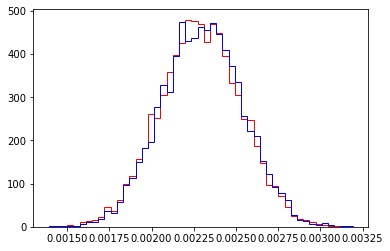

In [9]:
vx_red = np.hypot(trace['mx_red'][1000:][::5], trace['my_red'][1000:][::5])
vx_blue = np.hypot(trace['mx_blue'][1000:][::5], trace['my_blue'][1000:][::5])

lo = np.min([vx_red, vx_blue])
hi = np.max([vx_red, vx_blue])
bins = np.linspace(lo, hi, 50)

plt.hist(vx_red, histtype='step', color='red', bins=bins)
plt.hist(vx_blue, histtype='step', color='blue', bins=bins)

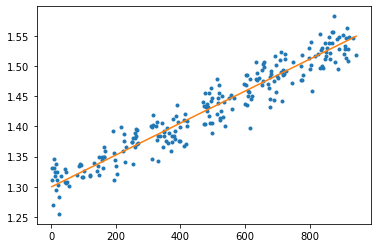

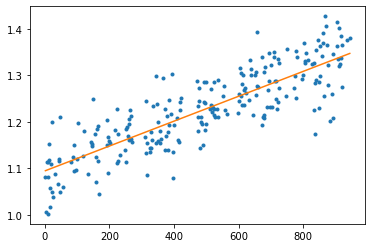

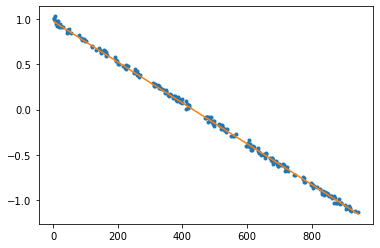

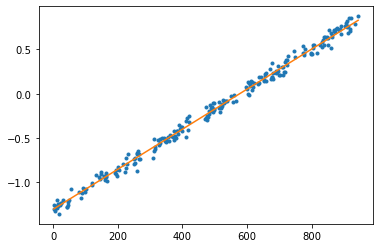

In [24]:
times = np.linspace(t['t'].min(), t['t'].max(), 1000)
plt.plot(t['t'], t['red_pos_X'], 'r.')
plt.plot(times, mx_red_med * times + bx_red_med, 'k', label='Median solution')
plt.xlabel('Time')
plt.ylabel('X pos')
plt.legend()
plt.show()

plt.plot(t['t'], t['blue_pos_X'], 'b.')
plt.plot(times, mx_blue_med * times + bx_blue_med, 'k')
plt.xlabel('Time')
plt.ylabel('X pos')
plt.show()

plt.plot(t['t'], t['red_pos_Y'], 'r.')
plt.plot(times, my_red_med * times + by_red_med, 'k')
plt.xlabel('Time')
plt.ylabel('X pos')
plt.show()

plt.plot(t['t'], t['blue_pos_Y'], 'b.')
plt.plot(times, my_blue_med * times + by_blue_med, 'k')
plt.xlabel('Time')
plt.ylabel('X pos')
plt.show()

In [25]:
print(px_red)
print(py_red)
print(px_blue)
print(py_blue)

[2.58402337e-04 1.30230585e+00]
[-0.00226272  0.98191362]
[2.70710365e-04 1.09354086e+00]
[ 0.00226952 -1.30433238]


In [26]:
print(mx_red_med, bx_red_med)
print(my_red_med, by_red_med)
print(mx_blue_med, bx_blue_med)
print(my_blue_med, by_blue_med)

0.00026489978352352126 1.2995664549001547
-0.0022487439832618275 0.9725320402143046
0.00026780380027134317 1.0944045829829456
0.002258313391449556 -1.3031772003013475


In [58]:
with pm.Model() as model:
    # Define priors.
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    mx_red = pm.Normal("mx_red", mu=px_red[0], sigma=1)
    bx_red = pm.Normal("bx_red", mu=px_red[1], sigma=1)
    mx_blue = pm.Normal("mx_blue", mu=px_blue[0], sigma=1)
    bx_blue = pm.Normal("bx_blue", mu=px_blue[1], sigma=1)
    my_red = pm.Normal("my_red", mu=py_red[0], sigma=1)
    by_red = pm.Normal("by_red", mu=py_red[1], sigma=1)
#    my_blue = pm.Normal("my_blue", mu=py_blue[0], sigma=1)
    my_blue = np.sqrt(mx_red**2 + my_red**2 - mx_blue**2) 
    by_blue = pm.Normal("by_blue", mu=py_blue[1], sigma=1)

    likelihood = pm.Normal("xred", mu=bx_red + mx_red*t['t'], sigma=sigma, observed=t['red_pos_X']) + \
                 pm.Normal("yred", mu=by_red + my_red*t['t'], sigma=sigma, observed=t['red_pos_Y']) + \
                 pm.Normal("xblue", mu=bx_blue + mx_blue*t['t'], sigma=sigma, observed=t['blue_pos_X']) + \
                 pm.Normal("yblue", mu=by_blue + my_blue*t['t'], sigma=sigma, observed=t['blue_pos_Y'])

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    step = pm.NUTS()
    trace = pm.sample(3000, step=[step], cores=2, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [by_blue, by_red, my_red, bx_blue, mx_blue, bx_red, mx_red, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 17 seconds.


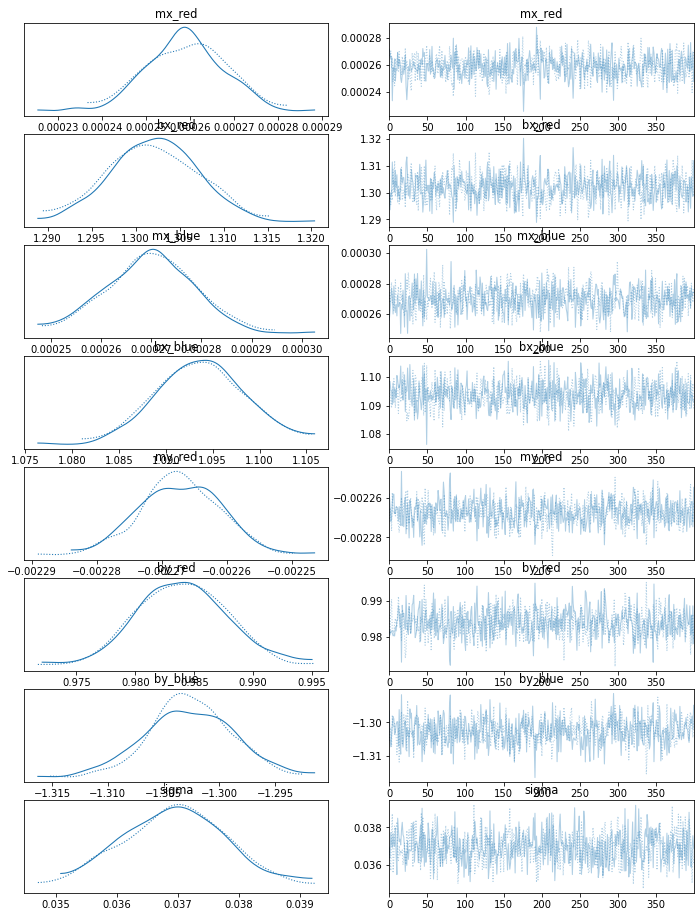

In [59]:
import arviz as az
with model:
    _ = az.plot_trace(trace[1000:][::5])

In [62]:
mx_red_med = trace['mx_red'][1000:][::5].sum()/len(trace['mx_red'][1000:][::5])
bx_red_med = trace['bx_red'][1000:][::5].sum()/len(trace['bx_red'][1000:][::5])
my_red_med = trace['my_red'][1000:][::5].sum()/len(trace['my_red'][1000:][::5])
by_red_med = trace['by_red'][1000:][::5].sum()/len(trace['by_red'][1000:][::5])
mx_blue_med = trace['mx_blue'][1000:][::5].sum()/len(trace['mx_blue'][1000:][::5])
bx_blue_med = trace['bx_blue'][1000:][::5].sum()/len(trace['bx_blue'][1000:][::5])
#my_blue_med = trace['my_blue'][1000:][::5].sum()/len(trace['my_blue'][1000:][::5])
my_blue_med = np.sqrt(mx_red_med**2 + my_red_med**2 - mx_blue_med**2)
by_blue_med = trace['by_blue'][1000:][::5].sum()/len(trace['by_blue'][1000:][::5])

(array([  4.,  15.,  67., 172., 272., 243., 151.,  63.,  12.,   1.]),
 array([0.00225996, 0.00226442, 0.00226887, 0.00227332, 0.00227778,
        0.00228223, 0.00228668, 0.00229114, 0.00229559, 0.00230004,
        0.0023045 ]),
 [<matplotlib.patches.Polygon at 0x7f4813a8cf10>])

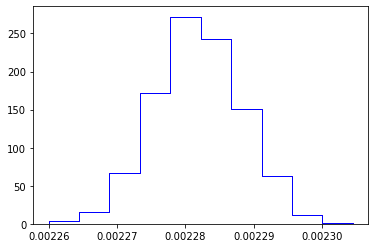

In [68]:
my_blue = np.sqrt(trace['mx_red'][1000:][::5]**2 + trace['my_red'][1000:][::5]**2 - trace['mx_blue'][1000:][::5]**2)
vx_red = np.hypot(trace['mx_red'][1000:][::5], trace['my_red'][1000:][::5])
vx_blue = np.hypot(trace['mx_blue'][1000:][::5], my_blue)

plt.hist(vx_red, histtype='step', color='red')
plt.hist(vx_blue, histtype='step', color='blue')

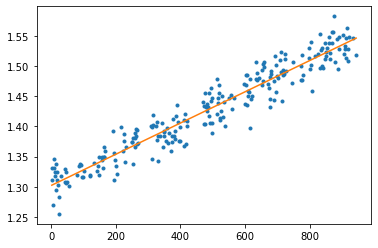

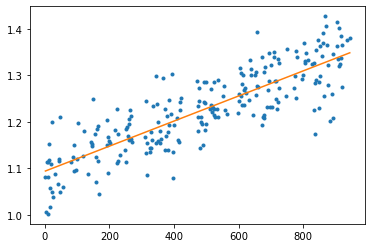

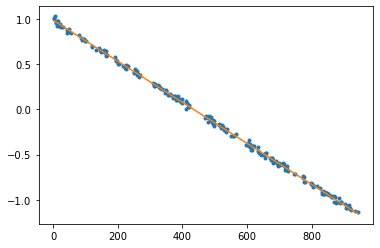

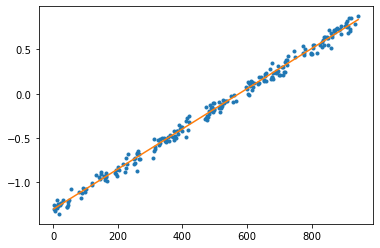

In [69]:
times = np.linspace(t['t'].min(), t['t'].max(), 1000)
plt.plot(t['t'], t['red_pos_X'], '.')
plt.plot(times, mx_red_med * times + bx_red_med)
plt.show()

plt.plot(t['t'], t['blue_pos_X'], '.')
plt.plot(times, mx_blue_med * times + bx_blue_med)
plt.show()

plt.plot(t['t'], t['red_pos_Y'], '.')
plt.plot(times, my_red_med * times + by_red_med)
plt.show()

plt.plot(t['t'], t['blue_pos_Y'], '.')
plt.plot(times, my_blue_med * times + by_blue_med)
plt.show()

b) What is the 5% and 95% confidence interval of the time range when the true Y value of the Blue object is => 0 AND the true Y value of Red <=0? That is, what are the 5% and 95% quantiles of the estimated first time when Y_blue >= 0 and Y_red <= 0?

c) If both objects are known to be moving at the same speed, how does you answer in a and b change? That is, that the total magnitude of the velocity (sqrt[vx2 + vy2]) is the same for each object.

d) Repeat your answers for a-c by using only the first 100 measurements? Do the changes make sense?